In [ ]:
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf


#티스토리 업로드시 최적화 코드
#from IPython.core.display import display, HTML
#display(HTML("<style>.container {width:90% !important;}</style>"))

# 2023.04.17
# TRAINING
Dataset Info.

train.csv [파일]

    ID : 샘플 고유 ID
    User-ID : 유저 고유 ID
    Book-ID : 도서 고유 ID
    유저 정보
    Age : 나이
    Location : 지역
    도서 정보
    Book-Title : 도서 명
    Book-Author : 도서 저자
    Year-Of-Publication : 도서 출판 년도 (-1일 경우 결측 혹은 알 수 없음)
    Publisher : 출판사
    Book-Rating : 유저가 도서에 부여한 평점 (0점 ~ 10점)


test.csv [파일]

    ID : 샘플 고유 ID
    User-ID : 유저 고유 ID
    Book-ID : 도서 고유 ID
    유저 정보
    Age : 나이
    Location : 지역
    도서 정보
    Book-Title : 도서 명
    Book-Author : 도서 저자
    Year-Of-Publication : 도서 출판 년도 (-1일 경우 결측 혹은 알 수 없음)
    Publisher : 출판사


sample_submission.csv [제출양식]

    ID : 샘플 고유 ID
    Book-Rating : 예측한 유저가 도서에 부여할 평점

In [ ]:
import pandas as pd

In [ ]:
import numpy as np
import random
import os
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_dir = '/content/drive/MyDrive/데이콘/데이콘 도서 추천 알고리즘'

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

In [ ]:
train = pd.read_csv(file_dir+'/train.csv')
test = pd.read_csv( file_dir+'/test.csv')
sample_submission = pd.read_csv(file_dir+'/sample_submission.csv', index_col = 0)

In [ ]:
train['City'] = [(i.split(',')[0]).lstrip().title() for i in train['Location']]
train['State'] = [(i.split(',')[1]).lstrip().title() for i in train['Location']]
train['Country'] = [(i.split(',')[2]).lstrip().title() for i in train['Location']]

In [ ]:
test['City'] = [(i.split(',')[0]).lstrip().title() for i in test['Location']]
test['State'] = [(i.split(',')[1]).lstrip().title() for i in test['Location']]
test['Country'] = [(i.split(',')[2]).lstrip().title() for i in test['Location']]

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 10.9 MB/s eta 0:00:00


In [ ]:
# 나이 그룹화
labels = ['0-3','3-6','6-8','8-12','12-18','18-25','25-34','35-44','45-54','55-64','65-74','75+']
bins = [0, 3, 6, 8, 12, 18, 25, 34, 44, 54, 64, 74, 250]
train['Age_gb'] = pd.cut(train.Age, bins, labels = labels,include_lowest = True)

In [ ]:
test['Age_gb'] = pd.cut(test.Age, bins, labels = labels,include_lowest = True)

In [ ]:
# BERTopic 속도 향상을 위한 작업
!pip install --extra-index-url https://download.pytorch.org/whl/cu117 --extra-index-url https://pypi.nvidia.com git+https://github.com/facebookresearch/dinov2
# 토픽 모델링을 위한 버토픽(BERTopic) 다운
!pip install bertopic[visualization]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu117, https://pypi.nvidia.com
  Cloning https://github.com/facebookresearch/dinov2 to /tmp/pip-req-build-f5_4keha
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/dinov2 /tmp/pip-req-build-f5_4keha
  Resolved https://github.com/facebookresearch/dinov2 to commit c3c2683a13cde94d4d99f523cf4170384b00c34c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.7/529.7 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 GB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [ ]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install stop-words
!pip install beautifulsoup4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32910 sha256=cf982b9a5ad24bd93f9d90bd2f70bb535c90a846c3cefb76140d76b249aa7445
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
Successfully built stop-words
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from stop_words import get_stop_words
# 불용어 리스트
languages = [
   'Arabic',
   'Bulgarian',
   'Catalan',
   'Czech',
   'Danish',
   'Dutch',
   'English',
   'Finnish',
   'French',
   'German',
   'Hungarian',
   'Indonesian',
   'Italian',
   'Norwegian',
   'Polish',
   'Portuguese',
   'Romanian',
   'Russian',
   'Spanish',
   'Swedish',
   'Turkish',
   'Ukrainian'
]
my_stop_word_list = []
for i in languages:
    my_stop_word_list.append(get_stop_words(i.lower()))
my_stop_word_list = sum(my_stop_word_list, [])
my_stop_word_list = my_stop_word_list + ['paperbook', 'hardcover']

In [ ]:
# https://gist.github.com/nealrs/96342d8231b75cf4bb82
contractions = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}


In [ ]:
from bs4 import BeautifulSoup
import re

def preprocessing_location(sentence, remove_stopwords = True):
    #소문자화
    sentence = sentence.lower()
    #괄호로 닫친 문자열 괄호 제거
    sentence = re.sub(r'\([^)]*\)',' ',sentence)
    #쌍따옴표 제거
    sentence = re.sub('"', ' ', sentence) 
    #소유격 제거
    sentence = re.sub(r"'s\b"," ",sentence)
    #특수문자 제거
    sentence = re.sub("[^a-zA-Z]"," ", sentence)
    
    #불용어 제거
    if my_stop_word_list:
        tokens = ' '.join(word for word in sentence.split() if not word in my_stop_word_list if len(word)>1)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word)>1)
    return tokens

#main 단어만 추출 > 차후 이 단어들로 BERTopic 테마 만들 것
def preprocessing_sentence(sentence, remove_stopwords = True):
    #소문자화
    sentence = sentence.lower()
    #html 태그 제거
    sentence = BeautifulSoup(sentence, "lxml").text
    #괄호로 닫친 문자열 괄호 제거
    sentence = re.sub(r'\([^)]*\)',' ',sentence)
    #쌍따옴표 제거
    sentence = re.sub('"', ' ', sentence) 
    #약어 정규화
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    #소유격 제거
    sentence = re.sub(r"'s\b"," ",sentence)
    #특수문자 제거
    sentence = re.sub("[^a-zA-Z]"," ", sentence)
    
    #불용어 제거
    if my_stop_word_list:
        tokens = ' '.join(word for word in sentence.split() if not word in my_stop_word_list if len(word)>1)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word)>1)
    return tokens



In [ ]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
#train['Book-Title_cl'] = 
train['Book-Title_st'] = [preprocessing_sentence(i) for i in train['Book-Title']]
test['Book-Title_st'] = [preprocessing_sentence(i) for i in test['Book-Title']]

In [ ]:
train['book_title_author'] = train['Book-Title_st'] + ' ' + train['Book-Author']
test['book_title_author'] = test['Book-Title_st'] + ' ' + test['Book-Author']

In [ ]:
! pip install pyarrow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pyarrow
from cuml.cluster import HDBSCAN
from cuml.manifold import UMAP
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import KeyBERTInspired
from cuml.preprocessing import normalize
from sentence_transformers import SentenceTransformer


np.random.seed(113)
# 벡터화 모델
vectorizer_model = CountVectorizer(stop_words=my_stop_word_list, ngram_range=(1, 2), min_df=10)

# Create instances of GPU-accelerated UMAP and HDBSCAN (GPU사용 모델)
umap_model = UMAP(n_components=5, n_neighbors=300, min_dist=0.0, metric='cosine', random_state =113)
hdbscan_model = HDBSCAN(metric='euclidean', min_samples=10, gen_min_span_tree=True, prediction_data=True)
# 불용어 처리
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
# Create your representation model
representation_model = KeyBERTInspired(random_state = 113)

model = BERTopic(vectorizer_model=vectorizer_model,
                 ctfidf_model=ctfidf_model,
                 umap_model=umap_model, 
                 hdbscan_model=hdbscan_model,
                 calculate_probabilities=True,
                 representation_model=representation_model,
                 # 다국어를 위해 해당 임베딩 모델 사용
                 embedding_model="paraphrase-multilingual-MiniLM-L12-v2",
                 nr_topics="auto",
                 low_memory = True,
                 language="multilingual",
                 verbose = True,
                 top_n_words = 5,
                 min_topic_size = 1000
                 )


In [ ]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

In [ ]:
title = train['book_title_author'].drop_duplicates().to_numpy()

model.fit(title)

Batches:   0%|          | 0/6584 [00:00<?, ?it/s]

2023-05-03 04:47:30,330 - BERTopic - Transformed documents to Embeddings
2023-05-03 04:48:37,280 - BERTopic - Reduced dimensionality
2023-05-03 04:49:00,334 - BERTopic - Clustered reduced embeddings
2023-05-03 04:49:37,882 - BERTopic - Reduced number of topics from 990 to 785


In [ ]:
topics, probs = model.transform(title)

Batches:   0%|          | 0/6584 [00:00<?, ?it/s]

2023-05-03 04:52:17,474 - BERTopic - Reduced dimensionality
2023-05-03 04:52:18,775 - BERTopic - Predicted clusters


In [ ]:
new_topics = model.reduce_outliers(title, topics,  strategy="distributions")

100%|██████████| 154/154 [00:10<00:00, 14.04it/s]


In [ ]:
model.update_topics(title, topics=new_topics)

In [ ]:
model.get_topic_info()

,Topic,Count,Name
0,-1,8801,-1_de_antonio_leben_mario
1,0,3090,0_cookbook_recipes_cooking_food
2,1,2649,1_fern_keene_michaels_carolyn
3,2,1886,2_bible_spiritual_prayer_meditations
4,3,1459,3_poems_shakespeare_poetry_selected
...,...,...,...
780,779,300,779_raven_lion_swan_mack
781,780,146,780_lincoln_abraham_liberty_agenda
782,781,315,781_york_zen_follow_reasons
783,782,336,782_juan_gone_julian_benã


In [ ]:
topic_words = ['-1: outlier']
for i in range(len(set(topics))-1):
  tpc = model.get_topic(i)[:7]
  words = [x[0] for x in tpc]
  tw = ' '.join([str(i) + ':'] + words)
  topic_words.append(tw)
topic_words

['-1: outlier',
 '0: cookbook recipes cooking food weight diet vegetarian',
 '1: fern keene michaels carolyn darcy nora drew',
 '2: bible spiritual prayer meditations prayers faith meditation',
 '3: poems shakespeare poetry selected poe edgar allan',
 '4: bride marriage wedding married marry weddings brides',
 '5: asimov isaac hawthorne alfred silverberg nathaniel austen',
 '6: christmas merry holiday santa holidays claus regency',
 '7: gay sex lesbian sexual women sexuality lesbians',
 '8: garden flowers gardening roses plants herbs flower',
 '9: japanese china chinese japan samurai ching naguib',
 '10: windows microsoft programming web internet visual server',
 '11: luis juan manuel carlos pedro perez javier',
 '12: pregnancy baby parents parent birth parenting child',
 '13: money business financial marketing management leadership investment',
 '14: murder death brett dying killing murders ngaio',
 '15: bird birds eagle butterfly field north parrot',
 '16: midnight night darkness twi

In [ ]:
title = train['book_title_author'].drop_duplicates().to_numpy()
title = pd.DataFrame(title, columns = ['book_title_author'])

In [ ]:
topic = pd.Series(new_topics, name = 'Topic_num')
topic

0         721
1           3
2         297
3         690
4          48
         ... 
210658    693
210659    691
210660    529
210661    650
210662    518
Name: Topic_num, Length: 210663, dtype: int64

In [ ]:
title = pd.concat([title, topic], axis =1)
title

,book_title_author,Topic_num
0,road taken Rona Jaffe,721
1,macbeth William Shakespeare,3
2,waverley Walter Scott,297
3,mother earth father sky Sue Harrison,690
4,remembers Linda Lay Shuler,48
...,...,...
210658,victorious Warren W. Wiersbe,693
210659,prodigals love study guide Stephen Griffith,691
210660,transatlantic love affair letters nelson algre...,529
210661,brother former racial foes offer strategy reco...,650


<Axes: xlabel='Topic_num', ylabel='Count'>

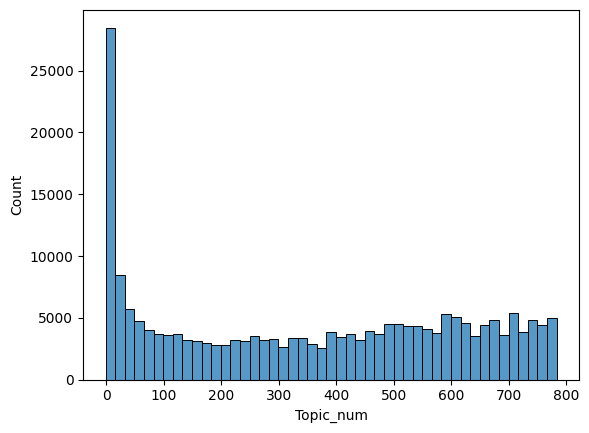

In [ ]:
import seaborn as sns
sns.histplot(title['Topic_num'])

In [ ]:
title_t = test['book_title_author'].drop_duplicates().to_numpy()

In [ ]:
topics_t, probs_t = model.transform(title_t)

Batches:   0%|          | 0/1824 [00:00<?, ?it/s]

2023-05-03 04:55:11,360 - BERTopic - Reduced dimensionality
2023-05-03 04:55:11,724 - BERTopic - Predicted clusters


In [ ]:
#아웃라이어를 제거,, 근데 테스트에도 사용해도 되나???
new_topics_t = model.reduce_outliers(title_t, topics_t,  strategy="distributions")

100%|██████████| 42/42 [00:03<00:00, 13.79it/s]


In [ ]:
topic_t = pd.Series(new_topics_t, name = 'Topic_num')
title_t = pd.DataFrame(title_t, columns = ['book_title_author'])
title_t = pd.concat([title_t, topic_t], axis =1)
title_t

,book_title_author,Topic_num
0,birds prey novel suspense J.A. Jance,376
1,midnight voices JOHN SAUL,217
2,breaking free prescription personal organizati...,583
3,bitter harvest Ann Rule,331
4,embraced light Betty J. Eadie,783
...,...,...
58359,changelings Jo Bannister,382
58360,marketing high technology William H. Davidow,772
58361,sierra notes images range light James Martin,736
58362,yards master golf short game Raymond Floyd,183


<Axes: xlabel='Topic_num', ylabel='Count'>

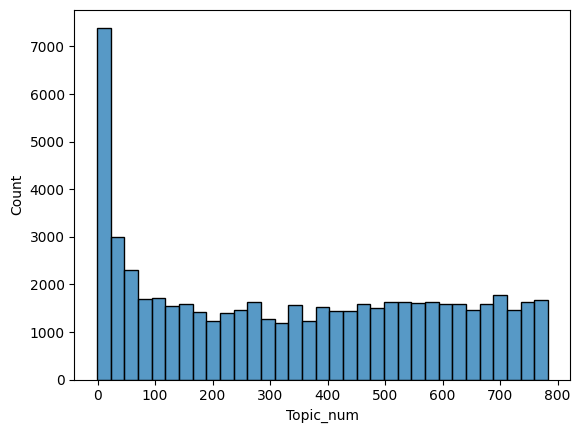

In [ ]:
import seaborn as sns
sns.histplot(title_t['Topic_num'])

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

FEATURE = ['User-ID', 'Book-Title','Book-Author','Publisher', 'City','State','Country','Age_gb']#,'Topic_num']

train_lb = train.__deepcopy__() 
test_lb = test.__deepcopy__()

train_lb = pd.merge(train_lb, title, on = 'book_title_author', how = 'left')
test_lb = pd.merge(test_lb, title_t, on = 'book_title_author', how = 'left')

train_lb = train_lb.drop(columns = ['Book-ID', 'Location'])
test_lb = test_lb.drop(columns = ['Book-ID', 'Location'])

train_lb[FEATURE] = train_lb[FEATURE].astype(str) 
test_lb[FEATURE] = test_lb[FEATURE].astype(str)

for i in FEATURE:
    # train에는 없고, test에는 있는 원소는 -2 처리
    oe = OrdinalEncoder(handle_unknown='use_encoded_value',
                         unknown_value=-2)
    oe=oe.fit(train_lb[i].to_numpy().reshape(-1, 1))
    train_lb[i] = oe.transform(train_lb[i].to_numpy().reshape(-1, 1))
    test_lb[i] = oe.transform(test_lb[i].to_numpy().reshape(-1, 1))

In [ ]:
train_lb

,ID,User-ID,Book-Rating,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,City,State,Country,Age_gb,Book-Title_st,book_title_author,Topic_num
0,TRAIN_000000,0.0,8,23.0,136251.0,77475.0,2001.0,9093.0,10518.0,1064.0,57.0,2.0,road taken,road taken Rona Jaffe,721
1,TRAIN_000001,0.0,8,23.0,103076.0,91647.0,1981.0,10515.0,10518.0,1064.0,57.0,2.0,macbeth,macbeth William Shakespeare,3
2,TRAIN_000002,0.0,0,23.0,208319.0,90102.0,1981.0,10515.0,10518.0,1064.0,57.0,2.0,waverley,waverley Walter Scott,297
3,TRAIN_000003,0.0,0,23.0,111765.0,83754.0,1991.0,1166.0,10518.0,1064.0,57.0,2.0,mother earth father sky,mother earth father sky Sue Harrison,690
4,TRAIN_000004,0.0,8,23.0,143993.0,54167.0,1989.0,12609.0,10518.0,1064.0,57.0,2.0,remembers,remembers Linda Lay Shuler,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871388,TRAIN_871388,83251.0,0,34.0,73499.0,52004.0,1993.0,6162.0,7730.0,981.0,321.0,3.0,healing words power prayer practice medicine,healing words power prayer practice medicine L...,2
871389,TRAIN_871389,83252.0,0,35.0,186183.0,16876.0,2002.0,6091.0,12110.0,1567.0,321.0,5.0,salmon doubt hitchhiking galaxy last time,salmon doubt hitchhiking galaxy last time DOUG...,34
871390,TRAIN_871390,83253.0,0,45.0,72770.0,36822.0,2000.0,13698.0,9104.0,1195.0,57.0,6.0,harry potter prisoner azkaban,harry potter prisoner azkaban J. K. Rowling,205
871391,TRAIN_871391,83254.0,8,43.0,73851.0,87010.0,1996.0,12989.0,7276.0,981.0,321.0,5.0,heartbreak hill anatomy ryder cup,heartbreak hill anatomy ryder cup Tim Rosaforte,286


In [ ]:
X_train = train_lb.drop(columns = ['ID','Book-Rating', 'book_title_author', 'Book-Title_st'])#,'Book-Title_st','City_st','State_st','Country_st'])
y_train = train_lb['Book-Rating']
x_test = test_lb.drop(columns = ['ID',  'book_title_author', 'Book-Title_st'])#,'Book-Title_st','City_st','State_st','Country_st'])

In [ ]:
from catboost import CatBoostRegressor 

model = CatBoostRegressor(random_seed = 113,
                          l2_leaf_reg = 0.003426034644149707,
                          max_bin = 358,
                          subsample = 0.9974697184313627,
                          learning_rate = 0.009464402227606937,
                          max_depth = 11,
                          min_data_in_leaf = 139,
                          eval_metric = 'RMSE',
                          iterations = 8694,
                          task_type='GPU',
                          bootstrap_type = 'Poisson',
                          early_stopping_rounds = 100,
                          verbose=500
                          )

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

k = 10 # a number of folds 
skfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=113)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from catboost import Pool

y_valid_pred = 0*y_train
y_test_pred = 0

FEATURE = ['User-ID', 'Book-Title','Book-Author','Publisher', 'City','State','Country','Age_gb']#, 'Topic_num']

for i, (train_index, test_index) in enumerate(skfold.split(X_train, y_train)):    
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    train_pool = Pool(data=X_train_fold.astype('int'), label=y_train_fold, cat_features=FEATURE)
    valid_pool = Pool(data=X_valid_fold.astype('int'), label=y_valid_fold, cat_features=FEATURE)

    print( "\nFold ", i)
    
    fit_model = model.fit(train_pool, 
                          eval_set=valid_pool,
                          use_best_model=True
                          )
    print( "  N trees = ", model.tree_count_ )
        
    # Generate validation predictions for this fold
    pred = fit_model.predict(X_valid_fold.astype('int'))
    y_valid_pred.iloc[test_index] = pred

    def score_model(model,X_train, X_test, y_train, y_test,
               show_plot=True):   
        y_pred = np.clip(model.predict(X_test.astype('int')),0,10)
        print(f"Test score: {r2_score(y_test, y_pred)}")
        print("MSE: ", mean_squared_error(y_test, y_pred))
        print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
    
        predictions_comparision = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).sample(25)
        if show_plot == True:
            predictions_comparision.plot(kind="bar", figsize=(12,8),title="Actual vs predicted values")
            print(predictions_comparision.sample(10))    
    
    
        return {
            "test_score_r2" : r2_score(y_test, y_pred),
            "test_score_mse" : mean_squared_error(y_test, y_pred),
            "test_score_rmse" : np.sqrt(mean_squared_error(y_test, y_pred))
            }
    score_model(fit_model, X_train_fold, X_valid_fold, y_train_fold, y_valid_fold, show_plot=True)
    
    # Predict value Clipping
    y_test_pred +=  np.clip(fit_model.predict(x_test[X_valid_fold.columns].astype('int')),0.0,10.0)
    
y_test_pred /= k  # Average test set predictions



Fold  0


0:	learn: 3.8401187	test: 3.8397490	best: 3.8397490 (0)	total: 335ms	remaining: 48m 35s
500:	learn: 3.3182399	test: 3.2864918	best: 3.2864918 (500)	total: 1m 33s	remaining: 25m 35s
1000:	learn: 3.2741903	test: 3.2675508	best: 3.2675508 (1000)	total: 3m 7s	remaining: 23m 59s
1500:	learn: 3.2439491	test: 3.2604866	best: 3.2604866 (1500)	total: 4m 45s	remaining: 22m 48s
2000:	learn: 3.2165476	test: 3.2564714	best: 3.2564714 (2000)	total: 6m 22s	remaining: 21m 18s
2500:	learn: 3.1912223	test: 3.2539497	best: 3.2539497 (2500)	total: 8m 1s	remaining: 19m 53s
3000:	learn: 3.1671912	test: 3.2518986	best: 3.2518986 (3000)	total: 9m 43s	remaining: 18m 26s
3500:	learn: 3.1441632	test: 3.2506067	best: 3.2506067 (3500)	total: 11m 24s	remaining: 16m 55s
4000:	learn: 3.1213114	test: 3.2494278	best: 3.2494278 (4000)	total: 13m 4s	remaining: 15m 19s
4500:	learn: 3.0997071	test: 3.2487405	best: 3.2487245 (4497)	total: 14m 45s	remaining: 13m 44s
5000:	learn: 3.0784989	test: 3.2480921	best: 3.2480921 (500

In [ ]:
sub = pd.DataFrame()
sub['ID'] = test['ID']
sub['Book-Rating'] = y_test_pred
sub

,ID,Book-Rating
0,TEST_000000,5.530954
1,TEST_000001,6.501299
2,TEST_000002,6.203025
3,TEST_000003,5.880463
4,TEST_000004,5.655802
...,...,...
159616,TEST_159616,3.667640
159617,TEST_159617,3.348060
159618,TEST_159618,4.021934
159619,TEST_159619,3.738853


<Axes: xlabel='Book-Rating', ylabel='Count'>

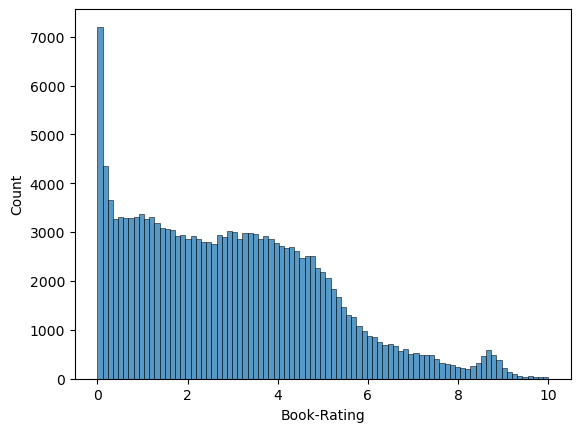

In [ ]:
import seaborn as sns
sns.histplot(sub['Book-Rating'])

In [ ]:
sub.to_csv('submit_cat+20-folds.csv', index=False,encoding="utf-8-sig")